In [42]:
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb

# from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import (
    Normalizer,
    FunctionTransformer,
    RobustScaler,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import (
    SelectFromModel,
    VarianceThreshold,
    chi2,
    SelectKBest,
    mutual_info_classif,
)
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, shapiro, probplot, ks_2samp
import category_encoders as ce
from catboost import CatBoostClassifier
from sklearn.tree import export_graphviz
from dython.model_utils import random_forest_feature_importance
import mlflow
import os
import logging
import yaml
import warnings
import pickle

In [2]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [32]:
warnings.filterwarnings("ignore")

with open("../params.yaml", "rb") as f:
    params = yaml.load(f, yaml.FullLoader)

mlflow.set_tracking_uri(params["ml_flow"]["MLFLOW_TRACKING_URI"])
os.environ["MLFLOW_TRACKING_USERNAME"] = params["ml_flow"][
    "MLFLOW_TRACKING_USERNAME"
]
os.environ["MLFLOW_TRACKING_PASSWORD"] = params["ml_flow"][
    "MLFLOW_TRACKING_PASSWORD"
]
mlflow.set_experiment("all_binary_experiments")
# mlflow.sklearn.autolog()
# mlflow.xgboost.autolog()
# mlflow.lightgbm.autolog()

In [4]:
# train_data = pd.read_parquet(
#     "../data/processed/chrome/08_12_2022/train_set_all_binary.parquet.gzip"
# )
# test_data = pd.read_parquet(
#     "../data/processed/chrome/08_12_2022/test_set_all_binary.parquet.gzip"
# )

train_data = pd.read_parquet(
        "../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip"
    )
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_processed.parquet.gzip"
    )

In [8]:
train_data = train_data.iloc[:, 4:-3]
test_data = test_data.iloc[:, 4:-3]

In [5]:
# train_data.reset_index(inplace=True, drop=True)
# test_data.reset_index(inplace=True, drop=True)

In [10]:
for elem in train_data.iloc[:, :-1].columns.values.tolist():
    train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
    test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)

In [13]:
train_data = train_data.iloc[:, 150:]
test_data = test_data.iloc[:, 150:]

for elem in train_data.columns.values.tolist():
    train_data[elem] = train_data[elem].astype("uint8")
    test_data[elem] = test_data[elem].astype("uint8")

def label_as_last_column(dataset):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = (
            temp_cols[0:index_col]
            + temp_cols[index_col + 1:]
            + temp_cols[index_col: index_col + 1]
    )
    return new_col_order

reordered_cols = label_as_last_column(train_data)
train_data = train_data[reordered_cols]
test_data = test_data[reordered_cols]

In [6]:
# %%time
# dummy_clf = DummyClassifier(strategy="most_frequent", random_state=10)
# dummy_clf.fit(X_train, y_train)
# dummy_clf.score(X_train, y_train)

CPU times: user 26.1 ms, sys: 1.84 ms, total: 27.9 ms
Wall time: 26.6 ms


0.7157431508360171

In [7]:
# model = RandomForestClassifier(
#     n_estimators=100,
#     n_jobs=-1,
#     random_state=10,
#     criterion="log_loss",
#     max_features=None,
# )

# model = KNeighborsClassifier(n_jobs=-1)
# model = DecisionTreeClassifier()
# model = GradientBoostingClassifier()
# model = HistGradientBoostingClassifier()
# model = xgb.XGBClassifier()
# model = lgb.LGBMClassifier(class_weight="balanced")
# model = CatBoostClassifier(thread_count=-1)
# model = MLPClassifier()
# model = LogisticRegression(n_jobs=-1, random_state=10)

In [9]:
def calculate_metrics(data, y_true):
    y_pred = model.predict(data)
    pred_probs = model.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print("Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Model auc score : {0:0.4f}".format(auc_score))
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print(metrics.classification_report(y_test, y_pred))

    disp_1 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp_2 = metrics.PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, name="KNN"
    )
    disp_3 = metrics.RocCurveDisplay.from_estimator(model, X_test, y_test)
    mlflow.log_figure(disp_1.figure_, "cm.png")
    mlflow.log_figure(disp_2.figure_, "prec_recall.png")
    mlflow.log_figure(disp_3.figure_, "roc.png")

In [15]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

del train_data
del test_data

Model accuracy score : 0.8329
Model log-loss score : 3.2883
Model auc score : 0.7802
Balanced accuracy score : 0.7802
F1 score : 0.6912
Precision score : 0.7279
Recall score : 0.6580
Matthews correlation coefficient score : 0.5785
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     48671
           1       0.73      0.66      0.69     19330

    accuracy                           0.83     68001
   macro avg       0.80      0.78      0.79     68001
weighted avg       0.83      0.83      0.83     68001



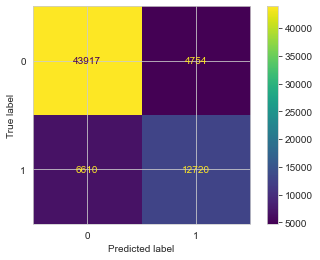

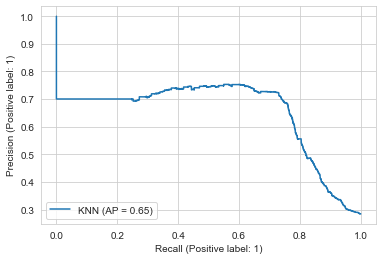

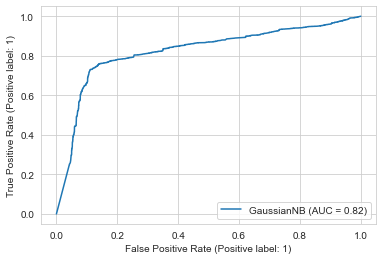

In [43]:
with mlflow.start_run():
    model = GaussianNB()

    model.fit(X_train, y_train["tracker"].to_numpy())
    calculate_metrics(X_test, y_test)
mlflow.end_run()

In [44]:
filename = "nb_binary.sav"
pickle.dump(model, open(f'../models/chrome/08_12_2022/{filename}', 'wb'))